In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import pi
import cv2
import scipy.misc
import tensorflow as tf

In [1]:
import pandas as pd

In [ ]:
! pip install scipy==1.1.0

In [15]:
# Importing ans reading data 
import scipy.misc
import random

xs = [] #will store all the image data 
ys = [] #will store the target variable

#points to the end of the last batch
train_batch_pointer = 0 #which will act as a pointer for batch loading 
val_batch_pointer = 0 

#read data.txt
with open("driving_dataset/data.txt") as f:
    for line in f:
        xs.append("driving_dataset/" + line.split()[0])
        #the paper by Nvidia uses the inverse of the turning radius,
        #but steering wheel angle is proportional to the inverse of turning radius
        #so the steering wheel angle in radians is used as the output
        ys.append(float(line.split()[1]) * scipy.pi / 180)

#get number of images
num_images = len(xs)

#gettig the training and validation datasets
train_xs = xs[:int(len(xs) * 0.7)] #we are considering first 70 percent data as train
train_ys = ys[:int(len(xs) * 0.7)] 

val_xs = xs[-int(len(xs) * 0.3):] #last 30% data as test data
val_ys = ys[-int(len(xs) * 0.3):]

num_train_images = len(train_xs)
num_val_images = len(val_xs)

print('Number of images in training data is:',num_train_images)
print('Number of images in test data is:',num_val_images)

Number of images in training data is: 31784
Number of images in test data is: 13621


In [16]:
train_xs

['driving_dataset/0.jpg',
 'driving_dataset/1.jpg',
 'driving_dataset/2.jpg',
 'driving_dataset/3.jpg',
 'driving_dataset/4.jpg',
 'driving_dataset/5.jpg',
 'driving_dataset/6.jpg',
 'driving_dataset/7.jpg',
 'driving_dataset/8.jpg',
 'driving_dataset/9.jpg',
 'driving_dataset/10.jpg',
 'driving_dataset/11.jpg',
 'driving_dataset/12.jpg',
 'driving_dataset/13.jpg',
 'driving_dataset/14.jpg',
 'driving_dataset/15.jpg',
 'driving_dataset/16.jpg',
 'driving_dataset/17.jpg',
 'driving_dataset/18.jpg',
 'driving_dataset/19.jpg',
 'driving_dataset/20.jpg',
 'driving_dataset/21.jpg',
 'driving_dataset/22.jpg',
 'driving_dataset/23.jpg',
 'driving_dataset/24.jpg',
 'driving_dataset/25.jpg',
 'driving_dataset/26.jpg',
 'driving_dataset/27.jpg',
 'driving_dataset/28.jpg',
 'driving_dataset/29.jpg',
 'driving_dataset/30.jpg',
 'driving_dataset/31.jpg',
 'driving_dataset/32.jpg',
 'driving_dataset/33.jpg',
 'driving_dataset/34.jpg',
 'driving_dataset/35.jpg',
 'driving_dataset/36.jpg',
 'driving_d

Populating the interactive namespace from numpy and matplotlib


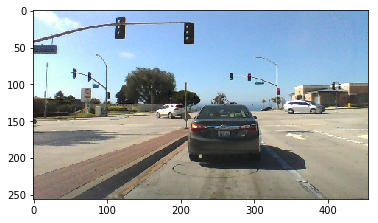

In [17]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread(train_xs[10514])
imgplot = plt.imshow(img)
plt.show()

In [18]:
import warnings
warnings.filterwarnings('ignore')

image_read = scipy.misc.imread(train_xs[0])# this reads the image and conferrs its size
print("original image size",image_read.shape)

#here we are cropping the image to get only the lower part which will be useful in computation
print("After taking the last 150 rows i.e lower part of the images where road is present, ",image_read[-150:].shape)
image_read = image_read[-150:]
resized_image = scipy.misc.imresize(image_read, [66, 200])
print("After resizing the images into 66*200, ",resized_image.shape)
# 200/66 = 455/150 = 3.0303 => we are keeping aspect ratio when we are resizing it

original image size (256, 455, 3)
After taking the last 150 rows i.e lower part of the images where road is present,  (150, 455, 3)
After resizing the images into 66*200,  (66, 200, 3)


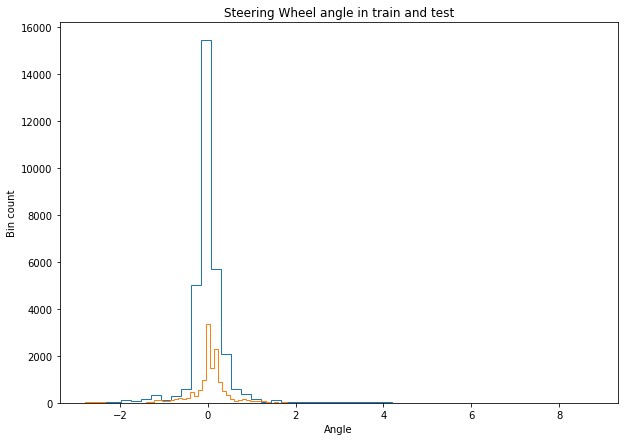

In [19]:

fig = plt.figure(figsize = (10, 7))
plt.hist(train_ys, bins = 50, histtype = "step")
plt.hist(val_ys, bins = 50, histtype = "step")
plt.title("Steering Wheel angle in train and test")
plt.xlabel("Angle")
plt.ylabel("Bin count")
plt.show()

In [20]:
#Model 0: Base line Model: y_test_pred = mean(y_train_i)
import numpy as np
train_mean_y = np.mean(train_ys)

print('Test_MSE(MEAN):%f' % np.mean(np.square(val_ys-train_mean_y)) )
print('Test_MSE(ZERO):%f' % np.mean(np.square(val_ys)) )


Test_MSE(MEAN):0.241559
Test_MSE(ZERO):0.241108


## Functions for batch loading train and validation data 

In [21]:
#writing functions for trainig and cross validation 

# you can break the whole line into parts like this
# here (train_batch_pointer + i) % num_train_images => "% num_train_images" is used to make sure that the
# (train_batch_pointer + i) values should not cross number of train images.

def LoadTrainBatch(batch_size):
    """will load the training data images with certified batch size """
    global train_batch_pointer #defining global for train pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        x_out.append(scipy.misc.imresize(scipy.misc.imread(train_xs[(train_batch_pointer + i) % num_train_images])[-150:], [66, 200]) / 255.0)
                                                                                                        #dividing by 255 to normalize the results
                #here (train_batch_pointer +i)%num_train_images is making sure that values do not cross  the number of train images
        y_out.append([train_ys[(train_batch_pointer + i) % num_train_images]])
    train_batch_pointer += batch_size
    return x_out, y_out

def LoadValBatch(batch_size):
    """will load the test data images with certified batch size"""
    global val_batch_pointer #defining gloabal for validation pointer 
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        x_out.append(scipy.misc.imresize(scipy.misc.imread(val_xs[(val_batch_pointer + i) % num_val_images])[-150:], [66, 200]) / 255.0)
        y_out.append([val_ys[(val_batch_pointer + i) % num_val_images]])
    val_batch_pointer += batch_size
    return x_out, y_out

## Deep learning architecture

In [22]:
import tensorflow as tf
import scipy

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1) #we are initializing the weights form truncated normal distribution
                                                   #with standard deviation of 0.1
    return tf.Variable(initial)

def bias_variable(shape):

    initial = tf.constant(0.1, shape=shape)# constant with desired shape
    return tf.Variable(initial)

def conv2d(x, W, stride):
    

    return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='VALID')#we are keeping padding here valid


In [23]:

x_input = tf.placeholder(tf.float32, shape=[None, 66, 200, 3])
#for the images where 66*200*3 signifies the 3d tensor of this size
#None signifies that we are using batch size here

y_ = tf.placeholder(tf.float32, shape=[None, 1])#for the output variable

x_image = x_input #input image

In [24]:
"""
First convolution layer
"""
#as we have 4 dim input [batch, in_height, in_width, in_channels]
# but we have to apply all these for [in_height, in_width] so we will make first and last to 1. 
W_conv1 = weight_variable([5, 5, 3, 24])
b_conv1 = bias_variable([24])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1, 2) + b_conv1)#output of first conv layer 
                                                          #input for second conv layer

"""
Second convolution layer
 """
W_conv2 = weight_variable([5, 5, 24, 36])
b_conv2 = bias_variable([36])
h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2, 2) + b_conv2)#output after 2nd convolution layer
                                                            #input for third conv layer

"""
Third convolution layer
"""
W_conv3 = weight_variable([5, 5, 36, 48])
b_conv3 = bias_variable([48])
h_conv3 = tf.nn.relu(conv2d(h_conv2, W_conv3, 2) + b_conv3)#output after 3rd convolution layer

"""Fourth convolution layer"""
W_conv4 = weight_variable([3, 3, 48, 64])
b_conv4 = bias_variable([64])
h_conv4 = tf.nn.relu(conv2d(h_conv3, W_conv4, 1) + b_conv4)#output after 4th convolution layer 

"""Ffith convolution layer"""
W_conv5 = weight_variable([3, 3, 64, 64])
b_conv5 = bias_variable([64])
h_conv5 = tf.nn.relu(conv2d(h_conv4, W_conv5, 1) + b_conv5)#output after 5th convolution layer 

"""Fully connected layer 1"""
keep_prob = tf.placeholder(tf.float32)#for adding dropout layer 
W_fc1 = weight_variable([1152, 1164])
b_fc1 = bias_variable([1164])
h_conv5_flat = tf.reshape(h_conv5, [-1, 1152])#flattening layer 
h_fc1 = tf.nn.relu(tf.matmul(h_conv5_flat, W_fc1) + b_fc1)#output of first fully connected layer
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)#adding the dropout layer

"""Fully connected layer 2"""
W_fc2 = weight_variable([1164, 100])
b_fc2 = bias_variable([100])
h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)#output of second fully connected layer
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

"""Fully connected layer 3"""
W_fc3 = weight_variable([100, 50])
b_fc3 = bias_variable([50])
h_fc3 = tf.nn.relu(tf.matmul(h_fc2_drop, W_fc3) + b_fc3)#output of third fully connected layer
h_fc3_drop = tf.nn.dropout(h_fc3, keep_prob)

"""Fully coonected layer 4"""
W_fc4 = weight_variable([50, 10])
b_fc4 = bias_variable([10])
h_fc4 = tf.nn.relu(tf.matmul(h_fc3_drop, W_fc4) + b_fc4)#output of fourth fully connected layer 
h_fc4_drop = tf.nn.dropout(h_fc4, keep_prob)

"""Output layer"""
W_fc5 = weight_variable([10, 1])
b_fc5 = bias_variable([1])
#for the final layer we will be considering the linear activation insted of atan
#where it will return us the same shape and content tensor
y_pred = tf.identity(tf.matmul(h_fc4_drop, W_fc5) + b_fc5)#scale the atan output

# Training the model

In [9]:
import os
import tensorflow as tf
from tensorflow.core.protobuf import saver_pb2

start = datetime.datetime.now()
LOGDIR = './save'
import warnings
warnings.filterwarnings('ignore')
sess = tf.InteractiveSession()

L2NormConst = 0.001

train_vars = tf.trainable_variables()

loss = tf.reduce_mean(tf.square(tf.subtract(val_ys,y_pred))) + tf.add_n([tf.nn.l2_loss(v) for v in train_vars]) * L2NormConst
train_step = tf.train.AdamOptimizer(1e-3).minimize(loss)
sess.run(tf.initialize_all_variables())

# create a summary to monitor cost tensor
tf.summary.scalar("loss", loss)
# merge all summaries into a single op
merged_summary_op =  tf.summary.merge_all()

saver = tf.train.Saver(write_version = saver_pb2.SaverDef.V1)

# op to write logs to Tensorboard
logs_path = './logs'
summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

epochs = 30
batch_size = 100

# train over the dataset about 30 times
for epoch in range(epochs):
    
    
    for i in range(int(num_images/batch_size)):
        xs, ys = LoadTrainBatch(batch_size)
        train_step.run(feed_dict={x_input: xs,y_: ys,keep_prob: 0.5})
        if i % 10 == 0:
            xs, ys = LoadValBatch(batch_size)
            loss_value = loss.eval(feed_dict={x_input:xs, y_: ys,keep_prob: 0.5})
            print("Epoch: %d, Step: %d, Loss: %g" % (epoch, epoch * batch_size + i, loss_value))

    # write logs at every iteration
        summary = merged_summary_op.eval(feed_dict={x_input:xs,y_: ys,keep_prob: 0.5})
        summary_writer.add_summary(summary, epoch * num_images/batch_size + i)

        if i % batch_size == 0:
            
            if not os.path.exists(LOGDIR):
                
                os.makedirs(LOGDIR)
            checkpoint_path = os.path.join(LOGDIR, "model.ckpt")
            filename = saver.save(sess, checkpoint_path)
    print("Model saved in file: %s" % filename)

print("Run the command line:\n" \
          "--> tensorboard --logdir=./logs " \
          "\nThen open http://0.0.0.0:6006/ into your web browser")


Instructions for updating:
Use `tf.global_variables_initializer` instead.
Epoch: 0, Step: 0, Loss: 6.81469
Epoch: 0, Step: 10, Loss: 5.87687
Epoch: 0, Step: 20, Loss: 5.42303
Epoch: 0, Step: 30, Loss: 5.00916
Epoch: 0, Step: 40, Loss: 4.63815
Epoch: 0, Step: 50, Loss: 4.31129
Epoch: 0, Step: 60, Loss: 4.0232
Epoch: 0, Step: 70, Loss: 3.76908
Epoch: 0, Step: 80, Loss: 3.5453
Epoch: 0, Step: 90, Loss: 3.34729
Epoch: 0, Step: 100, Loss: 3.17195
Epoch: 0, Step: 110, Loss: 3.01621
Epoch: 0, Step: 120, Loss: 2.87765
Epoch: 0, Step: 130, Loss: 2.75342
Epoch: 0, Step: 140, Loss: 2.6418
Epoch: 0, Step: 150, Loss: 2.54147
Epoch: 0, Step: 160, Loss: 2.45039
Epoch: 0, Step: 170, Loss: 2.3677
Epoch: 0, Step: 180, Loss: 2.29206
Epoch: 0, Step: 190, Loss: 2.22274
Epoch: 0, Step: 200, Loss: 2.15889
Epoch: 0, Step: 210, Loss: 2.09971
Epoch: 0, Step: 220, Loss: 2.04484
Epoch: 0, Step: 230, Loss: 1.99357
Epoch: 0, Step: 240, Loss: 1.94558
Epoch: 0, Step: 250, Loss: 1.90044
Epoch: 0, Step: 260, Loss: 1.85

### After saving the model and checkpoint in save directory we will run the run_dataset.py to visualize the output